<a href="https://colab.research.google.com/github/bhakriboy/APTOS-2019-Blindness-Detection/blob/master/241_project_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import sys
sys.path.append('/content/drive/My Drive/kaggle/efficientnet/efficientnet-master/efficientnet-master/')
from efficientnet import EfficientNetB5

In [0]:
import cv2
from google.colab.patches import cv2_imshow
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Path specifications
DATA_DIR = '/content/drive/My Drive/kaggle/aptos2019-blindness-detection/'
TRAIN_DF_PATH = DATA_DIR + "train.csv"
TEST_DF_PATH = DATA_DIR + 'test.csv'
TRAIN_IMG_PATH = DATA_DIR + "train_images/"
TEST_IMG_PATH = DATA_DIR + 'test_images/'

# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB5.h5'

# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

In [0]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)
# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [0]:
# Specify image size
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [0]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [0]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        
        :param epoch: The current epoch number
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

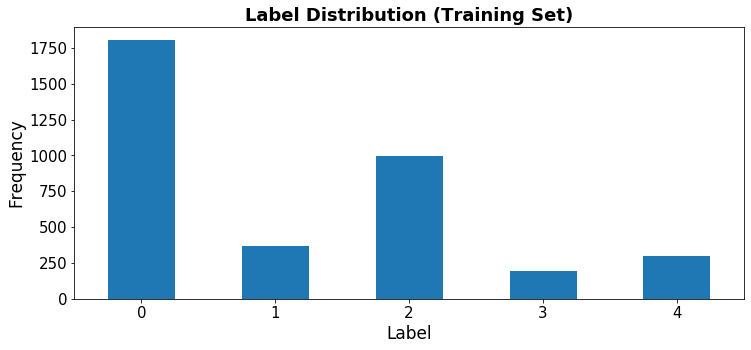

In [0]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


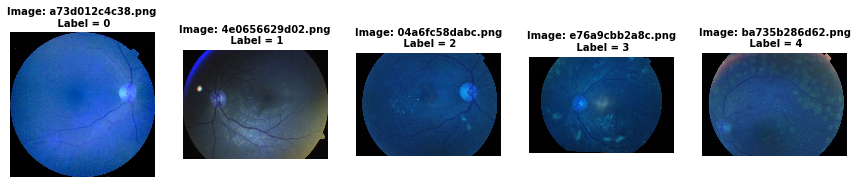

In [0]:
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);


In [0]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


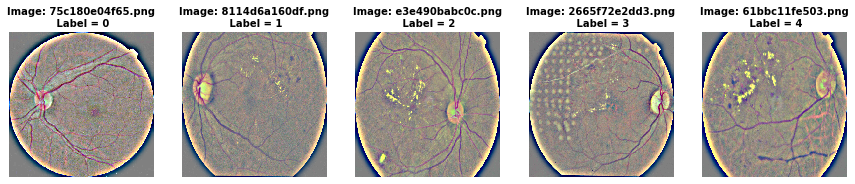

In [0]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{TRAIN_IMG_PATH}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [0]:
# Labels for training data
y_labels = train_df['diagnosis'].values

In [0]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 4

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 128.)

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other', 
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  subset='validation')

Found 3113 validated image filenames.
Found 549 validated image filenames.


In [0]:
class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)


    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [0]:
# Load in EfficientNetB5
effnet = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
effnet.load_weights('/content/drive/My Drive/kaggle/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')













Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
# Replace all Batch Normalization layers by Group Normalization layers
for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [0]:
def build_model():
    """
    A custom implementation of EfficientNetB5
    for the APTOS 2019 competition
    (Regression)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=RAdam(lr=0.00005), 
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model = build_model()

In [0]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
# Monitor MSE to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        epsilon=0.0001)

# Begin training
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=35,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es, rlr])
  

In [0]:
#Load best weights according to MSE
model.load_weights(SAVED_MODEL_NAME)


In [0]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [0]:
print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

In [0]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll


    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [0]:
# Optimize on validation data and evaluate again
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

In [0]:
# Place holder for diagnosis column
test_df['diagnosis'] = np.zeros(test_df.shape[0]) 
# For preprocessing test images
test_generator = ImageDataGenerator(preprocessing_function=preprocess_image, 
                                    rescale=1 / 128.).flow_from_dataframe(test_df, 
                                                                          x_col='id_code', 
                                                                          y_col='diagnosis',
                                                                          directory=TEST_IMG_PATH,
                                                                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                          batch_size=BATCH_SIZE,
                                                                          class_mode='other',
                                                                          shuffle=False)

In [0]:
# Make final predictions, round predictions and save to csv
y_test, _ = get_preds_and_labels(model, test_generator)
y_test = optR.predict(y_test, coefficients).astype(np.uint8)
test_df['diagnosis'] = y_test
# Remove .png from ids
test_df['id_code'] = test_df['id_code'].str.replace(r'.png$', '')
test_df.to_csv('submission.csv', index=False)

In [0]:
# Check submission
print("Submission File")
display(test_df.head())

In [0]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [0]:
# Distribution of predictions
test_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [0]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))